WaveNet MLP: Language Modeling (next char prediction) with multi-char context.
* Longer context length -> more parameters (ie for 2-layer MLP, first linear layer fan in dimension)
    * this should perform well because eval loss ~ training loss (not overfitting) so room to scale up
* Deeper with Progressive fusion 
    * vs 2-layer MLP had just a single layer to compress all the of info in the context


In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

%matplotlib inline

In [2]:
block_size = 8  # context length: num chars to predict the next one
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

In [3]:
# same as part 1

# load raw data: 32_033 names, length in [2, 15]
words = open("names.txt", "r").read().splitlines()

# build char vocabulary and tokenizer
chars = sorted(set("".join(words)))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"{vocab_size=}\nencoder {stoi=}\ndecoder {itos=}")

# shuffle words
random.seed(42)
random.shuffle(words)

vocab_size=27
encoder stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
decoder itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# same as part 2: prep the dataset
def build_dataset(words, block_size):
    X, Y = [], []

    for w in words:
        context = [0] * block_size  # encoded sequence "..."
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)  # 80% training
Xdev, Ydev = build_dataset(words[n1:n2], block_size)  # 10% dev
Xte, Yte = build_dataset(words[n2:], block_size)  # 10% test

# for x, y in zip(Xtr[:20], Ytr[:20]):
#     print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


# WaveNet

## Modules mimicing `torch.nn`: Layers and Containers

In [5]:
# Layers


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out  # [x.shape[0]:=n_samples, fan_out channels]

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


# -----------------------------------------------------------------------------------------------
# WARN self.training state important and must be set properly
# slight deviation for ndim == 3: PyTorch assumes dim 1 is the number of channels whereas we have it as dim 2
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
                # otherwise running_mean and running_var would have incorrect shape
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta  # not part of framework, only for vis
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


# -----------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        # num_embeddings is vocab_size
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return (
            self.out
        )  # [IX.shape[0]:=n_samples, IX.shape[1]:=context_length, embedding_dim]

    def parameters(self):
        return [self.weight]  # C

In [6]:
# Containers


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
# Customized for WaveNet
# Flattens the full minibatch [B, T*C] or consecutive sub-batches [B, T//n, C*n]
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

## Hierarchical Network Architecture

In [8]:
# # 2-Layer MLP
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(block_size), Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

## Train

In [9]:
# parameter init

# seed rng for reproducibility (simpler than generator object)
torch.manual_seed(42)

with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2954


  10000/ 200000: 2.1952
  20000/ 200000: 2.1917
  30000/ 200000: 2.1698
  40000/ 200000: 2.1259
  50000/ 200000: 2.0583
  60000/ 200000: 1.9110
  70000/ 200000: 1.7935
  80000/ 200000: 1.6461
  90000/ 200000: 1.9096
 100000/ 200000: 2.0316
 110000/ 200000: 1.7730
 120000/ 200000: 1.9143
 130000/ 200000: 2.0020
 140000/ 200000: 1.7146
 150000/ 200000: 1.8279
 160000/ 200000: 1.8710
 170000/ 200000: 1.9584
 180000/ 200000: 1.9546
 190000/ 200000: 1.8471


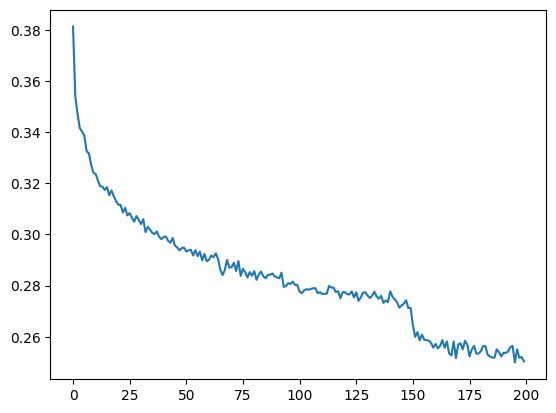

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
# shows step learning rate decay

In [12]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

# inspect sizes
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


torch.Size([1, 1, 128])

In [13]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.76809561252594
val 1.9840586185455322


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [14]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

rosa.
salider.
brinnly.
haylanni.
catherini.
devyn.
santana.
kipper.
gautit.
breyonce.
avery.
braylen.
jolee.
kayana.
kazmera.
erik.
gryed.
somarie.
danni.
cadian.


### Next time:
Why convolutions? Brief preview/hint: forward Linear layers efficiently over space
* ie 1D sequence sliding window filter: instead of n separate sequential calls to model, parallelize on cuda kernels
* high node reuse -> layer cache with filters -> efficient

In [15]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(
        Xtr[[7 + i]]
    )  # [1, 27]: forward a single sample of [1, context_length:=8]

........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
